In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import sys
from operator import itemgetter

import seaborn
seaborn.set()
from matplotlib import pyplot

logging.basicConfig(stream=sys.stdout, level=logging.getLevelName('INFO'))

def plot_rdm(similarities, title, ax):
    labels = similarities['stimulus_sentence'].values
    if isinstance(labels[0], tuple):
        labels = map(itemgetter(0), labels)
    labels = [label[:20] for label in labels]
    seaborn.heatmap(similarities, ax=ax)
    ax.set_title(title)
    ax.set_xticklabels(labels, rotation=90)
    ax.get_yaxis().set_visible(False)

def plot_rdms(rdm_titles, axes):
    for (rdm, title), ax in zip(rdm_titles, axes):
        plot_rdm(rdm, title, ax)


stories = ['Boar', 'KingOfBirds', 'Elvis', 'HighSchool']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Neural Data

In [2]:
from neural_nlp.neural_data import load_rdm_sentences
from neural_nlp.stimuli import load_stimuli

boar_data = load_rdm_sentences(story='Boar')
boar_data = boar_data.mean(dim='subject')
print(boar_data.shape, boar_data.dims)


(44, 47, 47) ('region', 'stimulus', 'stimulus')


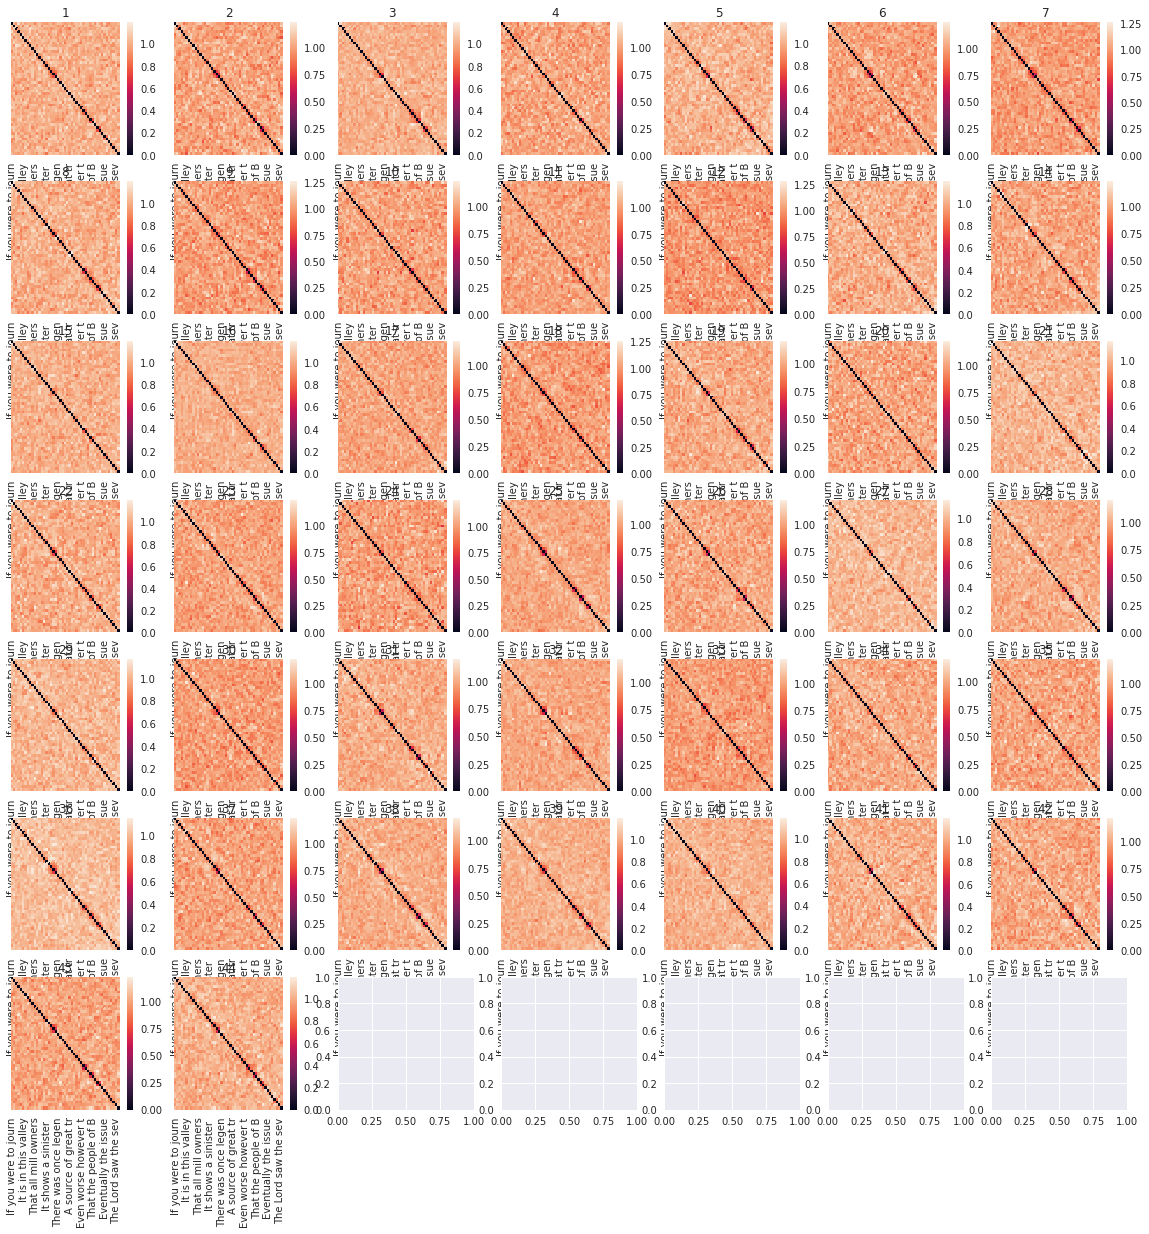

In [3]:
%matplotlib inline
import numpy as np

num_rows_cols = int(np.ceil(np.sqrt(len(boar_data['region']))))
fig, axes = pyplot.subplots(num_rows_cols, num_rows_cols, figsize=(20, 20))

generator = ((boar_data.sel(region=region), region) for region in boar_data['region'].values)
plot_rdms(generator, axes.flatten())

pyplot.savefig('results/RDM-neural-Boar.svg')
pyplot.savefig('results/RDM-neural-Boar.png')
fig

### Inter-region similarity

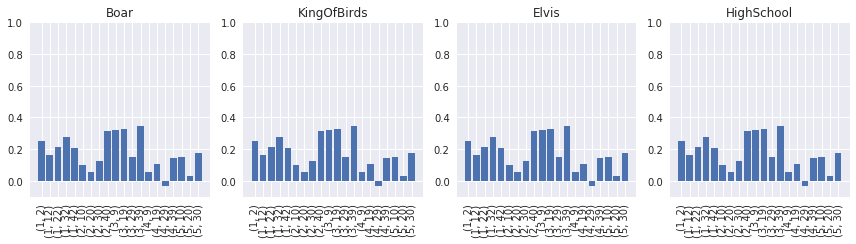

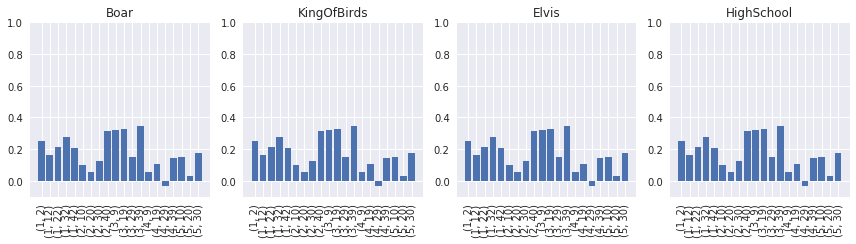

In [4]:
import itertools

from brainscore.metrics.rdm import RDMSimilarity

similarity = RDMSimilarity()
region_combinations = list(itertools.combinations(boar_data['region'].values, 2))[:200:10]

fig, axes = pyplot.subplots(1, len(stories), figsize=(12, 3.5))
for story, ax in zip(stories, axes):
    scores = {}
    for region_combination in region_combinations:
        rdms = [boar_data.sel(region=region) for region in region_combination]
        score = similarity(*rdms)
        scores[region_combination] = score
    x, y = list(scores.keys()), list(scores.values())
    ax.bar(range(len(x)), y)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(list(map(str, x)), rotation='vertical')
    ax.set_ylim(-.1, 1)
    ax.set_title(story)
fig.tight_layout()
pyplot.savefig('results/scores-interneural.svg')
pyplot.savefig('results/scores-interneural.png')
fig

## Models

In [21]:
% env MKL_THREADING_LAYER=GNU
models = ['skip-thoughts', 'lm_1b', 'transformer']

env: MKL_THREADING_LAYER=GNU


### Model RDMs

story Boar, model skip-thoughts


story Boar, model lm_1b


story Boar, model transformer


story KingOfBirds, model skip-thoughts


story KingOfBirds, model lm_1b


story KingOfBirds, model transformer


story Elvis, model skip-thoughts


story Elvis, model lm_1b


story Elvis, model transformer


story HighSchool, model skip-thoughts


story HighSchool, model lm_1b


story HighSchool, model transformer


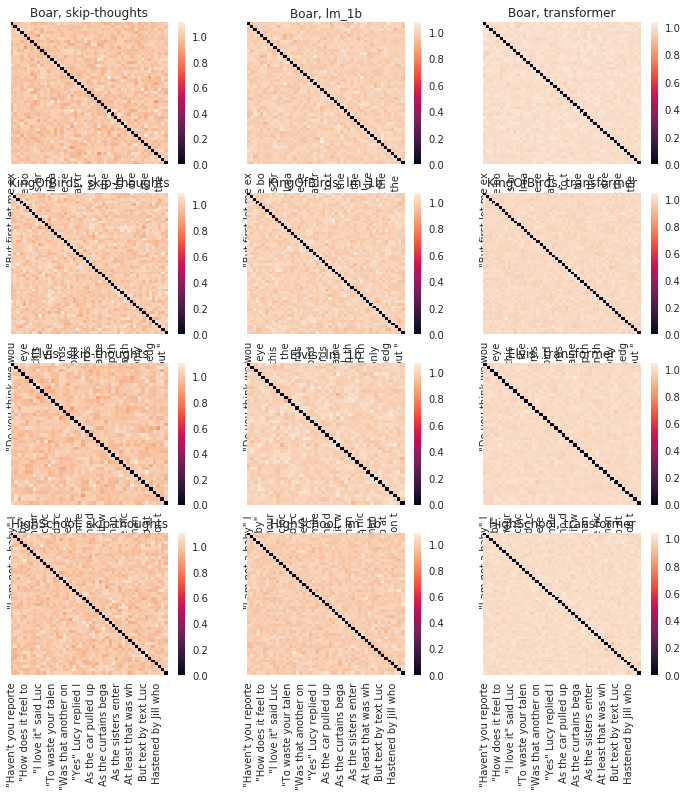

In [24]:
% matplotlib inline

import itertools

from matplotlib import pyplot
from mkgu.metrics.rdm import RDM

from neural_nlp.models import get_activations, model_layers
from neural_nlp.stimuli import load_stimuli

rdm = RDM()

def model_rdm_generator():
    for story, model_name in itertools.product(stories, models):
        # feed in sentences in context, i.e. with continuity
        layers = model_layers[model_name]
        encodings = get_activations(model_name=model_name, layers=layers,
                                    stimulus_set_name='naturalistic-neural-reduced.{}'.format(story))
        similarities = rdm(encodings)
        yield similarities, '{}, {}'.format(story, model_name)

fig, axes = pyplot.subplots(len(stories), len(models), figsize=(12, 12))
plot_rdms(model_rdm_generator(), axes.flatten())
pyplot.savefig('results/RDM-models.svg')
pyplot.savefig('results/RDM-models.png')
fig


### Inter-model similarity

{('skip-thoughts', 'lm_1b'): 0.7906700318790121, ('skip-thoughts', 'rntn'): 0.08557950521413818, ('lm_1b', 'rntn'): -0.03837452698017627}


{('skip-thoughts', 'lm_1b'): 0.8052811360992755, ('skip-thoughts', 'rntn'): 0.14034107144857022, ('lm_1b', 'rntn'): 0.1252880070011254}


{('skip-thoughts', 'lm_1b'): 0.7881961917454933, ('skip-thoughts', 'rntn'): -0.03307929056999651, ('lm_1b', 'rntn'): -0.0863060879768126}


{('skip-thoughts', 'lm_1b'): 0.8619874312026965, ('skip-thoughts', 'rntn'): -0.03861196197319735, ('lm_1b', 'rntn'): -0.014796781635264572}


/home/martin/miniconda3/envs/neural-nlp/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


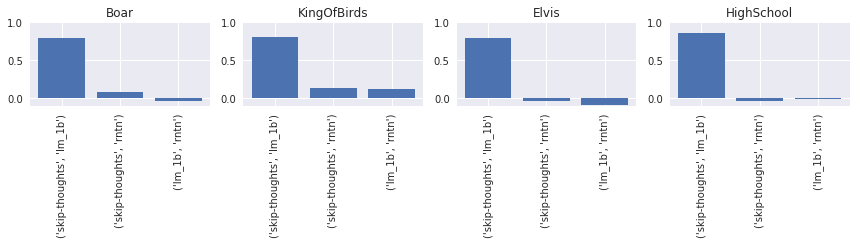

In [12]:
import itertools

from brainscore.metrics.rdm import RDM, RDMSimilarity

rdm = RDM()
similarity = RDMSimilarity()
model_combinations = list(itertools.combinations(models, 2))

fig, axes = pyplot.subplots(1, len(stories), figsize=(12, 3.5))
for story, ax in zip(stories, axes):
    scores = {}
    for model_combination in model_combinations:
        encodings = (get_activations(model, 'naturalistic-neural-reduced.{}'.format(story))
                     for model in model_combination)
        similarities = [rdm(encoding) for encoding in encodings]
        score = similarity(*similarities)
        scores[model_combination] = score
    print(scores)
    x, y = list(scores.keys()), list(scores.values())
    ax.bar(range(len(x)), y)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(list(map(str, x)), rotation='vertical')
    ax.set_ylim(-.1, 1)
    ax.set_title(story)
fig.tight_layout()
fig.show()
pyplot.savefig('results/scores-intermodel.svg')
pyplot.savefig('results/scores-intermodel.png')


## Model-region similarities

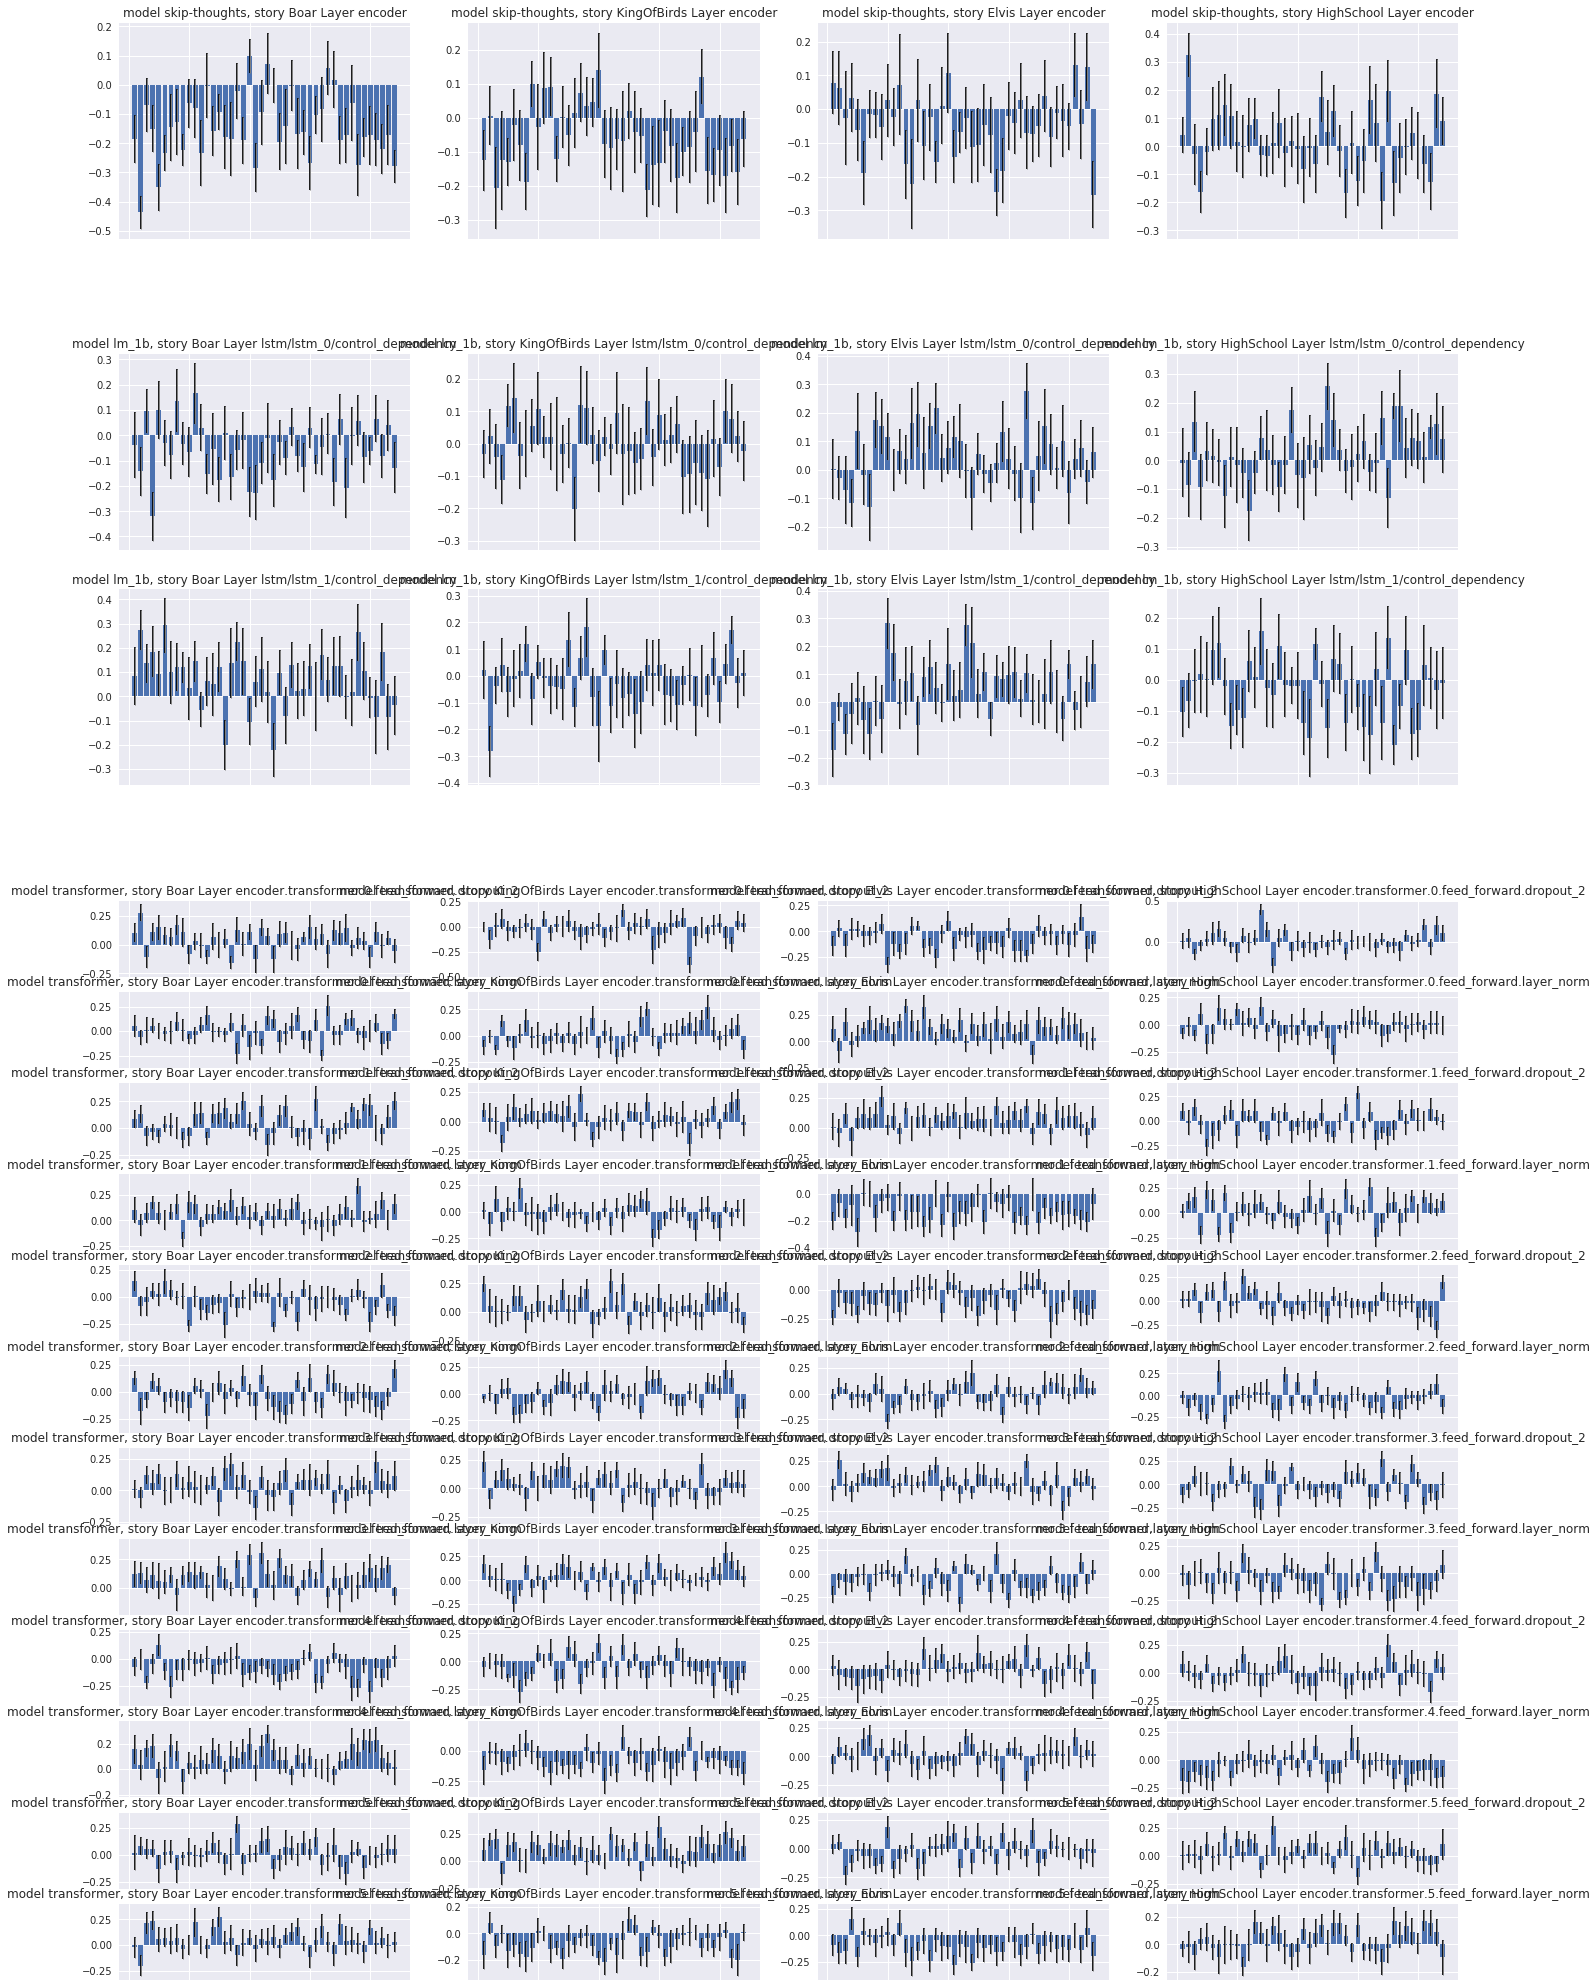

In [19]:
import itertools
import warnings

import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot

from neural_nlp.plot.model_region_similarities import plot_similarities

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

models = ['skip-thoughts', 'lm_1b', 'transformer']

fig = pyplot.figure(figsize=(len(stories) * 6, len(models) * 12))
model_story_grid = gridspec.GridSpec(len(models), len(stories),
                                     height_ratios=[1, 2, 5], wspace=.2, hspace=.2)

for i, (model, story) in enumerate(itertools.product(models, stories)):
    grid_cell = model_story_grid[i]
    plot_similarities(model, story, fig=fig, grid_spec=grid_cell, 
                      title_prefix=f"model {model}, story {story}")

pyplot.savefig('results/scores-neural.svg')
pyplot.savefig('results/scores-neural.png')
fig.show()
